In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Setup

In [ ]:
import pandas as pd
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import glob
import shutil
from shutil import copyfile
import os
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.preprocessing import label_binarize
import pickle
import feather
from itertools import cycle

In [ ]:
# Define paths:
pathtoTestImages = r'/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/Test'
pathtoPercentagesImages = r'/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/test_percentages/'
pathtoTimingsImages = r'/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/test_timings/'
pathtoTarget = r'/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/Test_SVM_Strategic_sophistication/'

pathtoSVMImages = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/Test_SVM_Strategic_sophistication/'
pathtoCSV = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/CSV_Files/'
pathtoModel = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Saved_models/SVM/'
pathtoSave = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Models_performance/SVM/Strategic_sophistication/'

In [ ]:
Categories=['cooperative','Level_1', 'equilibrium']
print("Type y to give categories");

while(True):
  check=input()
  if(check=='n' or check=='y'):
    break
  print("Please give a valid input (y/n)")
if(check=='y'):
  print("Enter How Many types of Images do you want to classify")
  n=int(input())
  Categories=[]
  print(f'please enter {n} names')
  for i in range(n):
    name=input()
    Categories.append(name)
  print(f"If not drive Please upload all the {n} category images in google collab with the same names as given in categories")


Type y to give categories
y
Enter How Many types of Images do you want to classify
3
please enter 3 names
cooperative
Level-1
equilibrium
If not drive Please upload all the 3 category images in google collab with the same names as given in categories


In [ ]:
# Define custom function for computing mAPk (mean Average Precision at k)
# Original source of code: https://books.google.it/books?id=ZbgAEAAAQBAJ&pg=PA64&lpg=PA64&dq=mapk+ml_metrics&source=bl&ots=Q1ZGckHUdP&sig=ACfU3U2vlYikcfzOCJAncxL8ueKH4pMX7w&hl=it&sa=X&ved=2ahUKEwjo-Mid57D0AhVGLewKHR_FCV4Q6AF6BAgNEAM#v=onepage&q=mapk%20ml_metrics&f=false
def pk(y_true, y_pred, k):
  if k==0:
    return 0
  y_pred = y_pred[:k]
  pred_set = set(y_pred)
  true_set = set(y_true)
  common_values = pred_set.intersection(true_set)
  return len(common_values) / len(y_pred[:k])

def apk(y_true, y_pred, k):
  pk_values = []
  for i in range(1, k+1):
    pk_values.append(pk(y_true, y_pred, i))
  if len(pk_values) ==0:
    return 0
  return sum(pk_values) / len(pk_values)

def mapk(y_true, y_pred, k):
  apk_values = []
  for i in range(len(y_true)):
    apk_values.append(
        apk(y_true[i], y_pred[i], k=k)
    )
  return sum(apk_values)/len(apk_values)

k = 16

# Test Full images


In [ ]:
#@title Folder for SVM maker 
RootDir = pathtoTestImages
TargetFolder = pathtoTarget + 'test_full'
for root, dirs, files in os.walk((os.path.normpath(RootDir)), topdown=False):
        for name in files:
            if name.endswith('.jpg'):
                print ("Found")
                SourceFolder = os.path.join(root,name)
                shutil.copy2(SourceFolder, TargetFolder) #copies csv to new folder


Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Foun

In [ ]:
#@title Conditions folders
rootdir_full = pathtoSVMImages + 'test_full'
output_path_full = pathtoSVMImages + 'test_full/'
csv = pathtoCSV + 'test_L1L2.csv'
no_ds = pd.read_csv(csv)
print(no_ds.columns)

for name in no_ds['code'][no_ds['Levels']==0]:
  os.rename(rootdir_full+'/'+name, rootdir_full+'/cooperative/'+name)

for name in no_ds['code'][no_ds['Levels']==1]:
  os.rename(rootdir_full+'/'+name, rootdir_full+'/Level_1/'+name)

for name in no_ds['code'][no_ds['Levels']==2]:
  os.rename(rootdir_full+'/'+name, rootdir_full+'/equilibrium/'+name)


Index(['code', 'Levels'], dtype='object')


In [ ]:
#@title Eliminate images outside of category folders
%%bash
cd /content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/Test_SVM_Levels/test_full/cooperative
ls -d | wc *.jpg

    1624     5142   302889 fase1_048e1_7.jpg
    1662     5863   385081 fase1_055e1_5.jpg
    5316     9318   364823 fase1_055e1_6.jpg
    1730     5523   350468 fase1_055e1_9.jpg
    1363     4597   303057 fase1_063e1_8.jpg
    1626     4737   294626 fase1_063e1_9.jpg
    1817     4070   220920 fase1_064e1_1.jpg
    1475     4644   300506 fase1_06e2_11.jpg
    1413     4303   282152 fase1_06e2_13.jpg
    5369     8524   290035 fase1_06e2_6.jpg
    1243     3792   246198 fase1_070e1_12.jpg
    1161     3931   245015 fase1_070e1_15.jpg
    1137     3287   220755 fase1_070e1_6.jpg
    1374     4103   267812 fase1_076e1_10.jpg
    1298     3946   238650 fase1_076e1_14.jpg
    1265     3206   208757 fase1_076e1_1.jpg
    1054     3076   210453 fase1_076e1_2.jpg
    1176     2908   186671 fase1_076e1_3.jpg
    1108     3698   245301 fase1_079e1_11.jpg
    1535     4234   254044 fase1_079e1_13.jpg
    1575     4203   257954 fase1_079e1_9.jpg
    1491     4692   312665 fase1_089e1_11.jpg
    

In [ ]:
#@title SVM dataframe maker

flat_data_arr=[]
target_arr=[]
#please use datadir='/content' if the files are upload on to google collab
#else mount the drive and give path of the parent-folder containing all category images folders.
datadir=pathtoSVMImages + 'test_full'
for i in Categories:
  print(f'loading... category : {i}')
  path=os.path.join(datadir,i)
  for img in os.listdir(path):
    img_array=imread(os.path.join(path,img))
    img_resized=resize(img_array,(224,224,3))
    flat_data_arr.append(img_resized.flatten())
    target_arr.append(Categories.index(i))
  print(f'loaded category:{i} successfully')
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data)
df['Target']=target
df

df.to_pickle(pathtoSVMImages + 'test_full/svm_df.pkl')

loading... category : cooperative
loaded category:cooperative successfully
loading... category : Level_1
loaded category:Level_1 successfully
loading... category : equilibrium
loaded category:equilibrium successfully


In [ ]:
#@title Load dataframe

df = pd.read_pickle(pathtoSVMImages + 'test_full/svm_df.pkl')

In [ ]:
#@title Load model
model = pickle.load(open(pathtoModel + 'svm_model_Strategic_sophistication.p','rb')) 
print(model)

SVC(C=10, gamma=0.0001)


In [ ]:
#@title Model predictions
x_test=df.iloc[:,:-1]
y_test=df.iloc[:,-1]
y_preds = model.predict(x_test)

In [ ]:
#@title Performance measures

#Classification report
print(classification_report(y_test, y_preds))

# get accuracy and confusion matrix:
print(f"The model is {accuracy_score(y_preds,y_test)*100}% accurate")

              precision    recall  f1-score   support

           0       0.50      0.15      0.23        54
           1       0.63      0.61      0.62        90
           2       0.61      0.85      0.71       106

    accuracy                           0.61       250
   macro avg       0.58      0.54      0.52       250
weighted avg       0.60      0.61      0.57       250

The model is 61.199999999999996% accurate


In [ ]:
#@title Save roc_auc 
labels = [0,1,2]
# Binarize ytest with shape (n_samples, n_classes)
y_test_bin = label_binarize(y_test, classes=labels)
# Binarize ypreds with shape (n_samples, n_classes)
y_preds_bin = label_binarize(y_preds, classes=labels)
macro = roc_auc_score(y_test_bin, y_preds_bin,average='macro',multi_class='ovr')
weighted = roc_auc_score(y_test_bin, y_preds_bin,average='weighted',multi_class='ovr')
roc = {'macro':  [macro],
        'weighted': [weighted],
        }
roc = pd.DataFrame(roc)
roc.to_csv(pathtoSave + 'roc_report_test_full.csv', index= True)

In [ ]:
# Compute mapk:
mapk_full = mapk(y_test_bin, y_preds_bin, k)
mapk_full

0.6899583333333343

In [ ]:
#@title Save performance results
cls = classification_report(y_test, y_preds, output_dict=True)
clsf_report = pd.DataFrame(cls).transpose()
clsf_report.to_csv(pathtoSave + 'classification_report_full_test.csv', index= True)

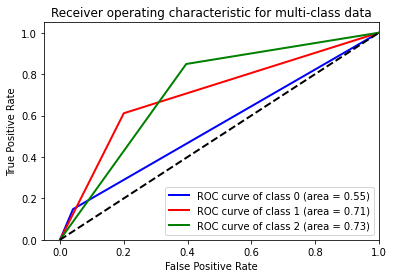

In [ ]:
#@title Plot ROC curve
# Original source of code for multiclass ROC plots: https://inblog.in/AUC-ROC-score-and-curve-in-multiclass-classification-problems-2ja4jOHb2X
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
lw = 2
for i in range(n_classes):
    
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_preds_bin[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.savefig(pathtoSave + 'roc_curve_test_full.png')

In [ ]:
#@title Remove dataframe and model
del df
del model
del y_test_bin
del y_preds_bin

# Test 80 Percent images


In [ ]:
#@title Folder for SVM maker 
RootDir = pathtoPercentagesImages + 'Test_80'
TargetFolder = pathtoTarget + 'test_80'
for root, dirs, files in os.walk((os.path.normpath(RootDir)), topdown=False):
        for name in files:
            if name.endswith('.jpg'):
                print ("Found")
                SourceFolder = os.path.join(root,name)
                shutil.copy2(SourceFolder, TargetFolder) #copies csv to new folder

Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Foun

In [ ]:
#@title Conditions folders
rootdir = pathtoSVMImages + 'test_80'
output_path = pathtoSVMImages + 'test_80/'
csv = pathtoCSV + 'test_L1L2.csv'
no_ds = pd.read_csv(csv)
print(no_ds.columns)

for name in no_ds['code'][no_ds['Levels']==0]:
  os.rename(rootdir+'/'+name, rootdir+'/cooperative/'+name)

for name in no_ds['code'][no_ds['Levels']==1]:
  os.rename(rootdir+'/'+name, rootdir+'/Level_1/'+name)

for name in no_ds['code'][no_ds['Levels']==2]:
  os.rename(rootdir+'/'+name, rootdir+'/equilibrium/'+name)


Index(['code', 'Levels'], dtype='object')


In [ ]:
#@title Eliminate images outside of category folders
%%bash
cd /content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/Test_SVM_Levels/test_80/cooperative
ls -d | wc *.jpg

    1048     4087   268344 fase1_048e1_7.jpg
    1747     5818   372052 fase1_055e1_5.jpg
    1759     5070   320006 fase1_055e1_6.jpg
    1186     4179   287688 fase1_055e1_9.jpg
    1366     4410   290375 fase1_063e1_8.jpg
    1394     4399   282516 fase1_063e1_9.jpg
    1152     2921   191342 fase1_064e1_1.jpg
    1420     4125   269300 fase1_06e2_11.jpg
    1368     3784   250201 fase1_06e2_13.jpg
    5329     8050   262417 fase1_06e2_6.jpg
    1312     3638   230232 fase1_070e1_12.jpg
    1183     3665   221801 fase1_070e1_15.jpg
    1128     3316   205349 fase1_070e1_6.jpg
    1461     4022   249261 fase1_076e1_10.jpg
    1546     3704   218206 fase1_076e1_14.jpg
    4803     6739   201417 fase1_076e1_1.jpg
    4483     6320   193641 fase1_076e1_2.jpg
    1009     2603   178177 fase1_076e1_3.jpg
    1089     3140   207238 fase1_079e1_11.jpg
    1256     3653   231016 fase1_079e1_13.jpg
    1065     3590   244216 fase1_079e1_9.jpg
    1776     4746   289224 fase1_089e1_11.jpg
    

In [ ]:
#@title SVM dataframe maker

flat_data_arr=[]
target_arr=[]
#please use datadir='/content' if the files are upload on to google collab
#else mount the drive and give path of the parent-folder containing all category images folders.
datadir=pathtoSVMImages + 'test_80'
for i in Categories:
  print(f'loading... category : {i}')
  path=os.path.join(datadir,i)
  for img in os.listdir(path):
    img_array=imread(os.path.join(path,img))
    img_resized=resize(img_array,(224,224,3))
    flat_data_arr.append(img_resized.flatten())
    target_arr.append(Categories.index(i))
  print(f'loaded category:{i} successfully')
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data)
df['Target']=target
df

df.to_pickle(pathtoSVMImages + 'test_80/svm_df.pkl')

loading... category : cooperative
loaded category:cooperative successfully
loading... category : Level_1
loaded category:Level_1 successfully
loading... category : equilibrium
loaded category:equilibrium successfully


In [ ]:
#@title Load dataframe
df = pd.read_pickle(pathtoSVMImages + 'test_80/svm_df.pkl')

In [ ]:
#@title Load model
model = pickle.load(open(pathtoModel + 'svm_model_Strategic_sophistication.p','rb')) 
print(model)

SVC(C=10, gamma=0.0001)


In [ ]:
#@title Model predictions
x_test=df.iloc[:,:-1]
y_test=df.iloc[:,-1]
y_preds = model.predict(x_test)

In [ ]:
#@title Performance measures

#Classification report
print(classification_report(y_test, y_preds))

# get accuracy and confusion matrix:
print(f"The model is {accuracy_score(y_preds,y_test)*100}% accurate")
print(confusion_matrix(y_preds,y_test))

              precision    recall  f1-score   support

           0       0.38      0.11      0.17        54
           1       0.61      0.63      0.62        90
           2       0.61      0.81      0.70       106

    accuracy                           0.60       250
   macro avg       0.53      0.52      0.50       250
weighted avg       0.56      0.60      0.56       250

The model is 59.599999999999994% accurate
[[ 6  4  6]
 [23 57 14]
 [25 29 86]]


In [ ]:
#@title Save roc_auc 
labels = [0,1,2]
# Binarize ytest with shape (n_samples, n_classes)
y_test_bin = label_binarize(y_test, classes=labels)
# Binarize ypreds with shape (n_samples, n_classes)
y_preds_bin = label_binarize(y_preds, classes=labels)
macro = roc_auc_score(y_test_bin, y_preds_bin,average='macro',multi_class='ovr') 
weighted = roc_auc_score(y_test_bin, y_preds_bin,average='weighted',multi_class='ovr')
roc = {'macro':  [macro],
        'weighted': [weighted],
        }
roc = pd.DataFrame(roc)
roc.to_csv(pathtoSave + 'roc_report_test_80.csv', index= True)

In [ ]:
# Compute mapk:
mapk_80 = mapk(y_test_bin, y_preds_bin,k)
mapk_80

0.6908333333333344

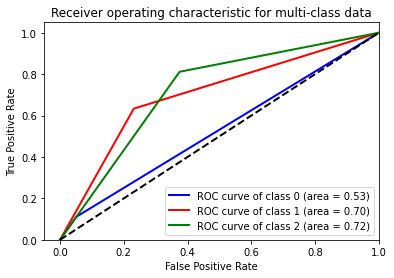

In [ ]:
#@title Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
lw = 2
for i in range(n_classes):
    
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_preds_bin[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.savefig(pathtoSave + 'roc_curve_test_80.png')

In [ ]:
#@title Save performance results
cls = classification_report(y_test, y_preds, output_dict=True)
clsf_report = pd.DataFrame(cls).transpose()
clsf_report.to_csv(pathtoSave + 'classification_report_80_test.csv', index= True)

In [ ]:
#@title Remove dataframe and model
del df
del model
del y_test_bin
del y_preds_bin

# Test 50 percent images

In [ ]:
#@title Folder for SVM maker 
RootDir = pathtoPercentagesImages + 'Test_50'
TargetFolder = pathtoTarget + 'test_50'
for root, dirs, files in os.walk((os.path.normpath(RootDir)), topdown=False):
        for name in files:
            if name.endswith('.jpg'):
                print ("Found")
                SourceFolder = os.path.join(root,name)
                shutil.copy2(SourceFolder, TargetFolder) #copies csv to new folder

Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Foun

In [ ]:
#@title Conditions folders
rootdir = pathtoSVMImages + 'test_50'
output_path = pathtoSVMImages + 'test_50/'
csv = pathtoCSV + 'test_L1L2.csv'
no_ds = pd.read_csv(csv)
print(no_ds.columns)

for name in no_ds['code'][no_ds['Levels']==0]:
  os.rename(rootdir+'/'+name, rootdir+'/cooperative/'+name)

for name in no_ds['code'][no_ds['Levels']==1]:
  os.rename(rootdir+'/'+name, rootdir+'/Level_1/'+name)

for name in no_ds['code'][no_ds['Levels']==2]:
  os.rename(rootdir+'/'+name, rootdir+'/equilibrium/'+name)


Index(['code', 'Levels'], dtype='object')


In [ ]:
#@title Eliminate images outside of category folders
%%bash
cd /content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/Test_SVM_Levels/test_50/cooperative
ls -d | wc *.jpg

    4949     7197   223118 fase1_048e1_7.jpg
    1367     4489   300401 fase1_055e1_5.jpg
    1651     4856   274761 fase1_055e1_6.jpg
    1230     3450   235225 fase1_055e1_9.jpg
    4649     7156   243529 fase1_063e1_8.jpg
    1194     3551   235498 fase1_063e1_9.jpg
    1021     2600   176738 fase1_064e1_1.jpg
    1209     3558   236941 fase1_06e2_11.jpg
    1111     3692   235262 fase1_06e2_13.jpg
    1450     3755   234282 fase1_06e2_6.jpg
    1043     2859   192148 fase1_070e1_12.jpg
    1000     2981   196817 fase1_070e1_15.jpg
    1262     3081   178087 fase1_070e1_6.jpg
    1347     3604   218592 fase1_076e1_10.jpg
     822     2640   189884 fase1_076e1_14.jpg
    1019     2711   182678 fase1_076e1_1.jpg
    1113     2804   180447 fase1_076e1_2.jpg
    1033     2451   165425 fase1_076e1_3.jpg
    1270     3286   186752 fase1_079e1_11.jpg
    1233     3290   207757 fase1_079e1_13.jpg
    1233     3646   215498 fase1_079e1_9.jpg
    1313     3938   253361 fase1_089e1_11.jpg
    

In [ ]:
#@title SVM dataframe maker
flat_data_arr=[]
target_arr=[]
#please use datadir='/content' if the files are upload on to google collab
#else mount the drive and give path of the parent-folder containing all category images folders.
datadir=pathtoSVMImages + 'test_50'
for i in Categories:
  print(f'loading... category : {i}')
  path=os.path.join(datadir,i)
  for img in os.listdir(path):
    img_array=imread(os.path.join(path,img))
    img_resized=resize(img_array,(224,224,3))
    flat_data_arr.append(img_resized.flatten())
    target_arr.append(Categories.index(i))
  print(f'loaded category:{i} successfully')
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data)
df['Target']=target
df

df.to_pickle(pathtoSVMImages + 'test_50/svm_df.pkl')

loading... category : cooperative
loaded category:cooperative successfully
loading... category : Level_1
loaded category:Level_1 successfully
loading... category : equilibrium
loaded category:equilibrium successfully


In [ ]:
#@title Load dataframe
df = pd.read_pickle(pathtoSVMImages + 'test_50/svm_df.pkl')

In [ ]:
#@title Load model
model = pickle.load(open(pathtoModel + 'svm_model_Strategic_sophistication.p','rb')) 
print(model)

SVC(C=10, gamma=0.0001)


In [ ]:
#@title Model predictions
x_test=df.iloc[:,:-1]
y_test=df.iloc[:,-1]
y_preds = model.predict(x_test)

In [ ]:
#@title Performance measures

#Classification report
print(classification_report(y_test, y_preds))

# get accuracy and confusion matrix:
print(f"The model is {accuracy_score(y_preds,y_test)*100}% accurate")
print(confusion_matrix(y_preds,y_test))

              precision    recall  f1-score   support

           0       0.27      0.13      0.18        54
           1       0.63      0.70      0.66        90
           2       0.63      0.74      0.68       106

    accuracy                           0.59       250
   macro avg       0.51      0.52      0.51       250
weighted avg       0.55      0.59      0.56       250

The model is 59.199999999999996% accurate
[[ 7  6 13]
 [22 63 15]
 [25 21 78]]


In [ ]:
#@title Save roc_auc 
labels = [0,1,2]
# Binarize ytest with shape (n_samples, n_classes)
y_test_bin = label_binarize(y_test, classes=labels)
# Binarize ypreds with shape (n_samples, n_classes)
y_preds_bin = label_binarize(y_preds, classes=labels)
macro = roc_auc_score(y_test_bin, y_preds_bin,average='macro',multi_class='ovr')
weighted = roc_auc_score(y_test_bin, y_preds_bin,average='weighted',multi_class='ovr')
roc = {'macro':  [macro],
        'weighted': [weighted],
        }
roc = pd.DataFrame(roc)
roc.to_csv(pathtoSave + 'roc_report_test_50.csv', index= True)

In [ ]:
# Compute mapk:
mapk_50 = mapk(y_test_bin, y_preds_bin,k)
mapk_50

0.6928333333333344

In [ ]:
#@title Save performance results
cls = classification_report(y_test, y_preds, output_dict=True)
clsf_report = pd.DataFrame(cls).transpose()
clsf_report.to_csv(pathtoSave + 'classification_report_50_test.csv', index= True)

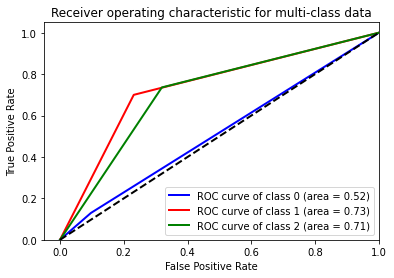

In [ ]:
#@title Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
lw = 2
for i in range(n_classes):
    
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_preds_bin[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.savefig(pathtoSave + 'roc_curve_test_50.png')

In [ ]:
#@title Remove dataframe and model
del df
del model
del y_test_bin
del y_preds_bin

# Test 30 percent images

In [ ]:
#@title Folder for SVM maker 
RootDir = pathtoPercentagesImages + 'Test_30'
TargetFolder = pathtoTarget + 'test_30'
for root, dirs, files in os.walk((os.path.normpath(RootDir)), topdown=False):
        for name in files:
            if name.endswith('.jpg'):
                print ("Found")
                SourceFolder = os.path.join(root,name)
                shutil.copy2(SourceFolder, TargetFolder) #copies csv to new folder

Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Foun

In [ ]:
#@title Conditions folders
rootdir = pathtoSVMImages + 'test_30'
output_path = pathtoSVMImages + 'test_30/'
csv = pathtoCSV + 'test_L1L2.csv'
no_ds = pd.read_csv(csv)
print(no_ds.columns)

for name in no_ds['code'][no_ds['Levels']==0]:
  os.rename(rootdir+'/'+name, rootdir+'/cooperative/'+name)

for name in no_ds['code'][no_ds['Levels']==1]:
  os.rename(rootdir+'/'+name, rootdir+'/Level_1/'+name)

for name in no_ds['code'][no_ds['Levels']==2]:
  os.rename(rootdir+'/'+name, rootdir+'/equilibrium/'+name)


Index(['code', 'Levels'], dtype='object')


In [ ]:
#@title Eliminate images outside of category folders
%%bash
cd /content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/Test_SVM_Levels/test_30/cooperative
ls -d | wc *.jpg

    986    2993  205597 fase1_048e1_7.jpg
   1262    3872  261938 fase1_055e1_5.jpg
   1433    3871  238031 fase1_055e1_6.jpg
    953    2859  192571 fase1_055e1_9.jpg
   1061    3430  215544 fase1_063e1_8.jpg
   1620    3470  198540 fase1_063e1_9.jpg
   4815    6183  159631 fase1_064e1_1.jpg
    994    2920  202492 fase1_06e2_11.jpg
   4837    6649  194202 fase1_06e2_13.jpg
   1500    3563  206236 fase1_06e2_6.jpg
   1054    2871  174353 fase1_070e1_12.jpg
   1493    3269  178879 fase1_070e1_15.jpg
   1388    3061  162453 fase1_070e1_6.jpg
   1477    3216  182170 fase1_076e1_10.jpg
   1063    2611  167200 fase1_076e1_14.jpg
   1266    2866  157694 fase1_076e1_1.jpg
   1220    2609  157923 fase1_076e1_2.jpg
   1021    2255  144337 fase1_076e1_3.jpg
    905    2391  166717 fase1_079e1_11.jpg
   1334    2848  172556 fase1_079e1_13.jpg
   1365    3197  186487 fase1_079e1_9.jpg
   1091    2973  195319 fase1_089e1_11.jpg
   1125    3146  207893 fase1_089e1_15.jpg
   1200    2533  163564 fas

In [ ]:
#@title SVM dataframe maker

flat_data_arr=[]
target_arr=[]
#please use datadir='/content' if the files are upload on to google collab
#else mount the drive and give path of the parent-folder containing all category images folders.
datadir= pathtoSVMImages + 'test_30'
for i in Categories:
  print(f'loading... category : {i}')
  path=os.path.join(datadir,i)
  for img in os.listdir(path):
    img_array=imread(os.path.join(path,img))
    img_resized=resize(img_array,(224,224,3))
    flat_data_arr.append(img_resized.flatten())
    target_arr.append(Categories.index(i))
  print(f'loaded category:{i} successfully')
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data)
df['Target']=target
df

df.to_pickle( pathtoSVMImages + 'test_30/svm_df.pkl')

loading... category : cooperative
loaded category:cooperative successfully
loading... category : Level_1
loaded category:Level_1 successfully
loading... category : equilibrium
loaded category:equilibrium successfully


In [ ]:
#@title Load dataframe
df = pd.read_pickle( pathtoSVMImages + 'test_30/svm_df.pkl')

In [ ]:
#@title Load model
model = pickle.load(open(pathtoModel + 'svm_model_Strategic_sophistication.p','rb')) 
print(model)

SVC(C=10, gamma=0.0001)


In [ ]:
#@title Model predictions
x_test=df.iloc[:,:-1]
y_test=df.iloc[:,-1]
y_preds = model.predict(x_test)

In [ ]:
#@title Performance measures

#Classification report
print(classification_report(y_test, y_preds))

# get accuracy and confusion matrix:
print(f"The model is {accuracy_score(y_preds,y_test)*100}% accurate")
print(confusion_matrix(y_preds,y_test))

              precision    recall  f1-score   support

           0       0.19      0.20      0.20        54
           1       0.51      0.66      0.58        90
           2       0.63      0.46      0.53       106

    accuracy                           0.48       250
   macro avg       0.44      0.44      0.44       250
weighted avg       0.49      0.48      0.48       250

The model is 47.599999999999994% accurate
[[11 19 27]
 [26 59 30]
 [17 12 49]]


In [ ]:
#@title Save roc_auc 
labels = [0,1,2]
# Binarize ytest with shape (n_samples, n_classes)
y_test_bin = label_binarize(y_test, classes=labels)
# Binarize ypreds with shape (n_samples, n_classes)
y_preds_bin = label_binarize(y_preds, classes=labels)
macro = roc_auc_score(y_test_bin, y_preds_bin,average='macro',multi_class='ovr')
weighted = roc_auc_score(y_test_bin, y_preds_bin,average='weighted',multi_class='ovr')
roc = {'macro':  [macro],
        'weighted': [weighted],
        }
roc = pd.DataFrame(roc)
roc.to_csv(pathtoSave + 'roc_report_test_30.csv', index= True)

In [ ]:
# Compute mapk:
mapk_30 = mapk(y_test_bin, y_preds_bin,k)
mapk_30

0.6985833333333346

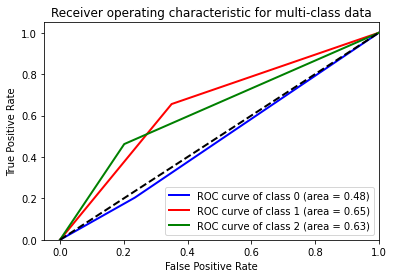

In [ ]:
#@title Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
lw = 2
for i in range(n_classes):
    
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_preds_bin[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.savefig(pathtoSave + 'roc_curve_test_30.png')

In [ ]:
#@title Save performance results
cls = classification_report(y_test, y_preds, output_dict=True)
clsf_report = pd.DataFrame(cls).transpose()
clsf_report.to_csv(pathtoSave + 'classification_report_30_test.csv', index= True)

In [ ]:
#@title Remove dataframe and model
del df
del model
del y_test_bin
del y_preds_bin

# Test 15 percentage images

In [ ]:
#@title Folder for SVM maker 
RootDir = pathtoPercentagesImages + 'Test_15'
TargetFolder = pathtoTarget + 'test_15'
for root, dirs, files in os.walk((os.path.normpath(RootDir)), topdown=False):
        for name in files:
            if name.endswith('.jpg'):
                print ("Found")
                SourceFolder = os.path.join(root,name)
                shutil.copy2(SourceFolder, TargetFolder) #copies csv to new folder

Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Foun

In [ ]:
#@title Conditions folders
rootdir = pathtoSVMImages + 'test_15'
output_path =  pathtoSVMImages + 'test_15/'
csv = pathtoCSV + 'test_L1L2.csv'
no_ds = pd.read_csv(csv)
print(no_ds.columns)

for name in no_ds['code'][no_ds['Levels']==0]:
  os.rename(rootdir+'/'+name, rootdir+'/cooperative/'+name)

for name in no_ds['code'][no_ds['Levels']==1]:
  os.rename(rootdir+'/'+name, rootdir+'/Level_1/'+name)

for name in no_ds['code'][no_ds['Levels']==2]:
  os.rename(rootdir+'/'+name, rootdir+'/equilibrium/'+name)

Index(['code', 'Levels'], dtype='object')


In [ ]:
#@title Eliminate images outside of category folders
%%bash
cd /content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/Test_SVM_Levels/test_15/cooperative
ls -d | wc *.jpg

   1051    2670  174939 fase1_048e1_7.jpg
   1093    3439  213714 fase1_055e1_5.jpg
   1635    3435  186684 fase1_055e1_6.jpg
   1403    2903  164952 fase1_055e1_9.jpg
    978    2846  190963 fase1_063e1_8.jpg
   1242    2835  174098 fase1_063e1_9.jpg
   5079    6388  149873 fase1_064e1_1.jpg
   4872    6519  174182 fase1_06e2_11.jpg
   1154    2768  168287 fase1_06e2_13.jpg
   1430    2843  163795 fase1_06e2_6.jpg
   1040    2319  150930 fase1_070e1_12.jpg
   1037    2326  146631 fase1_070e1_15.jpg
   1150    2331  142752 fase1_070e1_6.jpg
   1044    2375  150728 fase1_076e1_10.jpg
   1192    2484  154792 fase1_076e1_14.jpg
   1260    2462  141860 fase1_076e1_1.jpg
   1109    2338  146259 fase1_076e1_2.jpg
    914    2274  136831 fase1_076e1_3.jpg
   4591    5941  152156 fase1_079e1_11.jpg
   1181    2715  151097 fase1_079e1_13.jpg
    961    2288  155387 fase1_079e1_9.jpg
   1239    2531  155510 fase1_089e1_11.jpg
   1484    3112  176281 fase1_089e1_15.jpg
   1212    2430  142720 fas

In [ ]:
#@title SVM dataframe maker

flat_data_arr=[]
target_arr=[]
#please use datadir='/content' if the files are upload on to google collab
#else mount the drive and give path of the parent-folder containing all category images folders.
datadir= pathtoSVMImages + 'test_15'
for i in Categories:
  print(f'loading... category : {i}')
  path=os.path.join(datadir,i)
  for img in os.listdir(path):
    img_array=imread(os.path.join(path,img))
    img_resized=resize(img_array,(224,224,3))
    flat_data_arr.append(img_resized.flatten())
    target_arr.append(Categories.index(i))
  print(f'loaded category:{i} successfully')
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data)
df['Target']=target
df

df.to_pickle( pathtoSVMImages + 'test_15/svm_df.pkl')

loading... category : cooperative
loaded category:cooperative successfully
loading... category : Level_1
loaded category:Level_1 successfully
loading... category : equilibrium
loaded category:equilibrium successfully


In [ ]:
#@title Load dataframe
df = pd.read_pickle( pathtoSVMImages + 'test_15/svm_df.pkl')

In [ ]:
#@title Load model
model = pickle.load(open(pathtoModel + 'svm_model_Strategic_sophistication.p','rb')) 
print(model)

SVC(C=10, gamma=0.0001)


In [ ]:
#@title Model predictions
x_test=df.iloc[:,:-1]
y_test=df.iloc[:,-1]
y_preds = model.predict(x_test)

In [ ]:
#@title Performance measures

#Classification report
print(classification_report(y_test, y_preds))

# get accuracy and confusion matrix:
print(f"The model is {accuracy_score(y_preds,y_test)*100}% accurate")
print(confusion_matrix(y_preds,y_test))

              precision    recall  f1-score   support

           0       0.23      0.28      0.25        54
           1       0.41      0.68      0.51        90
           2       0.50      0.17      0.25       106

    accuracy                           0.38       250
   macro avg       0.38      0.38      0.34       250
weighted avg       0.41      0.38      0.35       250

The model is 37.6% accurate
[[15 20 29]
 [30 61 59]
 [ 9  9 18]]


In [ ]:
#@title Save roc_auc 
labels = [0,1,2]
# Binarize ytest with shape (n_samples, n_classes)
y_test_bin = label_binarize(y_test, classes=labels)
# Binarize ypreds with shape (n_samples, n_classes)
y_preds_bin = label_binarize(y_preds, classes=labels)
macro = roc_auc_score(y_test_bin, y_preds_bin,average='macro',multi_class='ovr')
weighted = roc_auc_score(y_test_bin, y_preds_bin,average='weighted',multi_class='ovr')
roc = {'macro':  [macro],
        'weighted': [weighted],
        }
roc = pd.DataFrame(roc)
roc.to_csv(pathtoSave + 'roc_report_test_15.csv', index= True)

In [ ]:
# Compute mapk:
mapk_15 = mapk(y_test_bin, y_preds_bin,k)
mapk_15

0.7038333333333345

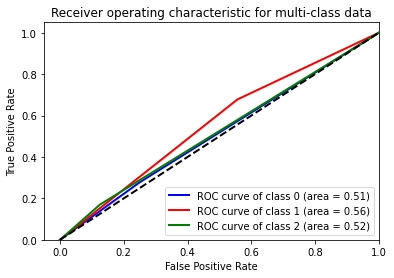

In [ ]:
#@title Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
lw = 2
for i in range(n_classes):
    
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_preds_bin[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.savefig(pathtoSave + 'roc_curve_test_15.png')

In [ ]:
#@title Save performance results
cls = classification_report(y_test, y_preds, output_dict=True)
clsf_report = pd.DataFrame(cls).transpose()
clsf_report.to_csv(pathtoSave + 'classification_report_15_test.csv', index= True)

In [ ]:
#@title Remove dataframe and model
del df
del model
del y_test_bin
del y_preds_bin

# Test 15 seconds images

In [ ]:
#@title Folder for SVM maker 
RootDir = pathtoTimingsImages + 'Test_15s'
TargetFolder = pathtoTarget + 'test_15s'
for root, dirs, files in os.walk((os.path.normpath(RootDir)), topdown=False):
        for name in files:
            if name.endswith('.jpg'):
                print ("Found")
                SourceFolder = os.path.join(root,name)
                shutil.copy2(SourceFolder, TargetFolder) #copies csv to new folder

Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Foun

In [ ]:
#@title Conditions folders
rootdir =  pathtoSVMImages + 'test_15s'
output_path =  pathtoSVMImages + 'test_15s/'
csv = pathtoCSV + 'test_L1L2.csv'
no_ds = pd.read_csv(csv)
print(no_ds.columns)

for name in no_ds['code'][no_ds['Levels']==0]:
  os.rename(rootdir+'/'+name, rootdir+'/cooperative/'+name)

for name in no_ds['code'][no_ds['Levels']==1]:
  os.rename(rootdir+'/'+name, rootdir+'/Level_1/'+name)

for name in no_ds['code'][no_ds['Levels']==2]:
  os.rename(rootdir+'/'+name, rootdir+'/equilibrium/'+name)

Index(['code', 'Levels'], dtype='object')


In [ ]:
#@title Eliminate images outside of category folders
%%bash
cd /content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/Test_SVM_Levels/test_15s/cooperative
ls -d | wc *.jpg

    1334     3923   251437 fase1_048e1_7.jpg
    1159     3890   264951 fase1_055e1_5.jpg
    1567     3891   227933 fase1_055e1_6.jpg
    1235     3202   210987 fase1_055e1_9.jpg
    1320     4011   265428 fase1_063e1_8.jpg
    4734     7164   242923 fase1_063e1_9.jpg
    1831     4205   220915 fase1_064e1_1.jpg
    1624     4289   263854 fase1_06e2_11.jpg
    1082     3544   253276 fase1_06e2_13.jpg
    1443     3938   251209 fase1_06e2_6.jpg
    1300     3809   245105 fase1_070e1_12.jpg
    1347     4058   238086 fase1_070e1_15.jpg
    1640     3759   217551 fase1_070e1_6.jpg
    1707     4400   266356 fase1_076e1_10.jpg
    1217     3499   233091 fase1_076e1_14.jpg
    1058     2999   207436 fase1_076e1_1.jpg
    1281     3175   200039 fase1_076e1_2.jpg
    1209     2869   183229 fase1_076e1_3.jpg
    1210     3640   240754 fase1_079e1_11.jpg
    4913     7551   252605 fase1_079e1_13.jpg
    1427     4168   248620 fase1_079e1_9.jpg
    1160     3946   273011 fase1_089e1_11.jpg
    

In [ ]:
#@title SVM dataframe maker

flat_data_arr=[]
target_arr=[]
#please use datadir='/content' if the files are upload on to google collab
#else mount the drive and give path of the parent-folder containing all category images folders.
datadir= pathtoSVMImages + 'test_15s'
for i in Categories:
  print(f'loading... category : {i}')
  path=os.path.join(datadir,i)
  for img in os.listdir(path):
    img_array=imread(os.path.join(path,img))
    img_resized=resize(img_array,(224,224,3))
    flat_data_arr.append(img_resized.flatten())
    target_arr.append(Categories.index(i))
  print(f'loaded category:{i} successfully')
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data)
df['Target']=target
df

df.to_pickle( pathtoSVMImages + 'test_15s/svm_df.pkl')

loading... category : cooperative
loaded category:cooperative successfully
loading... category : Level_1
loaded category:Level_1 successfully
loading... category : equilibrium
loaded category:equilibrium successfully


In [ ]:
#@title Load dataframe
df = pd.read_pickle( pathtoSVMImages + 'test_15s/svm_df.pkl')

In [ ]:
#@title Load model
model = pickle.load(open(pathtoModel + 'svm_model_Strategic_sophistication.p','rb')) 
print(model)

SVC(C=10, gamma=0.0001)


In [ ]:
#@title Model predictions
x_test=df.iloc[:,:-1]
y_test=df.iloc[:,-1]
y_preds = model.predict(x_test)

In [ ]:
#@title Performance measures

#Classification report
print(classification_report(y_test, y_preds))

# get accuracy and confusion matrix:
print(f"The model is {accuracy_score(y_preds,y_test)*100}% accurate")
print(confusion_matrix(y_preds,y_test))

              precision    recall  f1-score   support

           0       0.42      0.15      0.22        54
           1       0.63      0.63      0.63        90
           2       0.64      0.84      0.72       106

    accuracy                           0.62       250
   macro avg       0.56      0.54      0.52       250
weighted avg       0.59      0.62      0.58       250

The model is 61.6% accurate
[[ 8  7  4]
 [21 57 13]
 [25 26 89]]


In [ ]:
#@title Save roc_auc 
labels = [0,1,2]
# Binarize ytest with shape (n_samples, n_classes)
y_test_bin = label_binarize(y_test, classes=labels)
# Binarize ypreds with shape (n_samples, n_classes)
y_preds_bin = label_binarize(y_preds, classes=labels)
macro = roc_auc_score(y_test_bin, y_preds_bin,average='macro',multi_class='ovr')
weighted = roc_auc_score(y_test_bin, y_preds_bin,average='weighted',multi_class='ovr')
roc = {'macro':  [macro],
        'weighted': [weighted],
        }
roc = pd.DataFrame(roc)
roc.to_csv(pathtoSave + 'roc_report_test_15s.csv', index= True)

In [ ]:
# Compute mapk:
mapk_15s = mapk(y_test_bin, y_preds_bin,k)
mapk_15s

0.6908333333333344

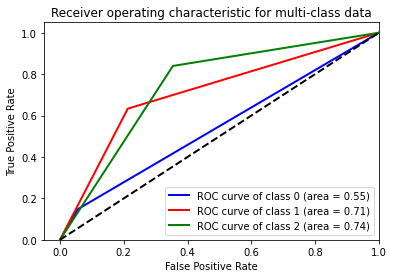

In [ ]:
#@title Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
lw = 2
for i in range(n_classes):
    
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_preds_bin[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.savefig(pathtoSave + 'roc_curve_test_15s.png')

In [ ]:
#@title Save performance results
cls = classification_report(y_test, y_preds, output_dict=True)
clsf_report = pd.DataFrame(cls).transpose()
clsf_report.to_csv(pathtoSave + 'classification_report_15s_test.csv', index= True)

In [ ]:
#@title Remove dataframe and model
del df
del model
del y_test_bin
del y_preds_bin

# Test 10 seconds images

In [ ]:
#@title Folder for SVM maker 
RootDir = pathtoTimingsImages + 'Test_10s'
TargetFolder = pathtoTarget + 'test_10s'
for root, dirs, files in os.walk((os.path.normpath(RootDir)), topdown=False):
        for name in files:
            if name.endswith('.jpg'):
                print ("Found")
                SourceFolder = os.path.join(root,name)
                shutil.copy2(SourceFolder, TargetFolder) #copies csv to new folder

Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Foun

In [ ]:
#@title Conditions folders
rootdir = pathtoSVMImages + 'test_10s'
output_path = pathtoSVMImages + 'test_10s/'
csv = pathtoCSV + 'test_L1L2.csv'
no_ds = pd.read_csv(csv)
print(no_ds.columns)

for name in no_ds['code'][no_ds['Levels']==0]:
  os.rename(rootdir+'/'+name, rootdir+'/cooperative/'+name)

for name in no_ds['code'][no_ds['Levels']==1]:
  os.rename(rootdir+'/'+name, rootdir+'/Level_1/'+name)

for name in no_ds['code'][no_ds['Levels']==2]:
  os.rename(rootdir+'/'+name, rootdir+'/equilibrium/'+name)

Index(['code', 'Levels'], dtype='object')


In [ ]:
#@title Eliminate images outside of category folders
%%bash
cd /content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/Test_SVM_Levels/test_10s/cooperative
ls -d | wc *.jpg

    1134     3537   216875 fase1_048e1_7.jpg
    1353     3712   235195 fase1_055e1_5.jpg
    1161     3114   201477 fase1_055e1_6.jpg
    1242     3078   194326 fase1_055e1_9.jpg
    1249     3371   221031 fase1_063e1_8.jpg
    1058     3099   208261 fase1_063e1_9.jpg
    1367     3114   189200 fase1_064e1_1.jpg
    1206     3615   237656 fase1_06e2_11.jpg
    1560     3908   237992 fase1_06e2_13.jpg
    1334     3425   218985 fase1_06e2_6.jpg
    1163     3588   224125 fase1_070e1_12.jpg
    5038     7310   220038 fase1_070e1_15.jpg
    1640     3759   217551 fase1_070e1_6.jpg
    1361     3787   240842 fase1_076e1_10.jpg
    1236     3530   228019 fase1_076e1_14.jpg
    1058     2999   207436 fase1_076e1_1.jpg
    1281     3175   200039 fase1_076e1_2.jpg
    1209     2869   183229 fase1_076e1_3.jpg
    1110     2941   193052 fase1_079e1_11.jpg
    1521     4119   249755 fase1_079e1_13.jpg
    1204     3771   248715 fase1_079e1_9.jpg
    1152     3437   224877 fase1_089e1_11.jpg
    

In [ ]:
#@title SVM dataframe maker

flat_data_arr=[]
target_arr=[]
#please use datadir='/content' if the files are upload on to google collab
#else mount the drive and give path of the parent-folder containing all category images folders.
datadir=pathtoSVMImages + 'test_10s'
for i in Categories:
  print(f'loading... category : {i}')
  path=os.path.join(datadir,i)
  for img in os.listdir(path):
    img_array=imread(os.path.join(path,img))
    img_resized=resize(img_array,(224,224,3))
    flat_data_arr.append(img_resized.flatten())
    target_arr.append(Categories.index(i))
  print(f'loaded category:{i} successfully')
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data)
df['Target']=target
df

df.to_pickle(pathtoSVMImages + 'test_10s/svm_df.pkl')

loading... category : cooperative
loaded category:cooperative successfully
loading... category : Level_1
loaded category:Level_1 successfully
loading... category : equilibrium
loaded category:equilibrium successfully


In [ ]:
#@title Load dataframe
df = pd.read_pickle(pathtoSVMImages + 'test_10s/svm_df.pkl')

In [ ]:
#@title Load model
model = pickle.load(open(pathtoModel + 'svm_model_Strategic_sophistication.p','rb')) 
print(model)

SVC(C=10, gamma=0.0001)


In [ ]:
#@title Model predictions
x_test=df.iloc[:,:-1]
y_test=df.iloc[:,-1]
y_preds = model.predict(x_test)

In [ ]:
#@title Performance measures

#Classification report
print(classification_report(y_test, y_preds))

# get accuracy and confusion matrix:
print(f"The model is {accuracy_score(y_preds,y_test)*100}% accurate")
print(confusion_matrix(y_preds,y_test))

              precision    recall  f1-score   support

           0       0.39      0.20      0.27        54
           1       0.64      0.68      0.66        90
           2       0.65      0.78      0.71       106

    accuracy                           0.62       250
   macro avg       0.56      0.55      0.55       250
weighted avg       0.59      0.62      0.60       250

The model is 62.0% accurate
[[11  7 10]
 [21 61 13]
 [22 22 83]]


In [ ]:
#@title Save roc_auc 
labels = [0,1,2]
# Binarize ytest with shape (n_samples, n_classes)
y_test_bin = label_binarize(y_test, classes=labels)
# Binarize ypreds with shape (n_samples, n_classes)
y_preds_bin = label_binarize(y_preds, classes=labels)
macro = roc_auc_score(y_test_bin, y_preds_bin,average='macro',multi_class='ovr')
weighted = roc_auc_score(y_test_bin, y_preds_bin,average='weighted',multi_class='ovr')
roc = {'macro':  [macro],
        'weighted': [weighted],
        }
roc = pd.DataFrame(roc)
roc.to_csv(pathtoSave + 'roc_report_test_10s.csv', index= True)

In [ ]:
# Compute mapk:
mapk_10s = mapk(y_test_bin, y_preds_bin,k)
mapk_10s

0.6924583333333344

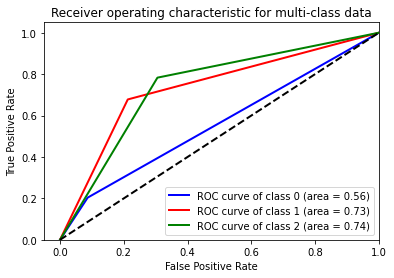

In [ ]:
#@title Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
lw = 2
for i in range(n_classes):
    
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_preds_bin[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.savefig(pathtoSave + 'roc_curve_test_10s.png')

In [ ]:
#@title Save performance results
cls = classification_report(y_test, y_preds, output_dict=True)
clsf_report = pd.DataFrame(cls).transpose()
clsf_report.to_csv(pathtoSave + 'classification_report_10s_test.csv', index= True)

In [ ]:
#@title Remove dataframe and model
del df
del model
del y_test_bin
del y_preds_bin

# Test 5 seconds images

In [ ]:
#@title Folder for SVM maker 
RootDir = pathtoTimingsImages + 'Test_5s'
TargetFolder = pathtoTarget + 'test_5s'
for root, dirs, files in os.walk((os.path.normpath(RootDir)), topdown=False):
        for name in files:
            if name.endswith('.jpg'):
                print ("Found")
                SourceFolder = os.path.join(root,name)
                shutil.copy2(SourceFolder, TargetFolder) #copies csv to new folder

Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Foun

In [ ]:
#@title Conditions folders
rootdir = pathtoSVMImages + 'test_5s'
output_path = pathtoSVMImages + 'test_5s/'
csv = pathtoCSV + 'test_L1L2.csv'
no_ds = pd.read_csv(csv)
print(no_ds.columns)

for name in no_ds['code'][no_ds['Levels']==0]:
  os.rename(rootdir+'/'+name, rootdir+'/cooperative/'+name)

for name in no_ds['code'][no_ds['Levels']==1]:
  os.rename(rootdir+'/'+name, rootdir+'/Level_1/'+name)

for name in no_ds['code'][no_ds['Levels']==2]:
  os.rename(rootdir+'/'+name, rootdir+'/equilibrium/'+name)

Index(['code', 'Levels'], dtype='object')


In [ ]:
#@title Eliminate images outside of category folders
%%bash
cd /content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/Test_SVM_Levels/test_5s/cooperative
ls -d | wc *.jpg

     884     2909   185670 fase1_048e1_7.jpg
    1248     3064   188135 fase1_055e1_5.jpg
    1221     2819   178248 fase1_055e1_6.jpg
    1076     2574   160689 fase1_055e1_9.jpg
    4483     6487   197908 fase1_063e1_8.jpg
    1339     2980   177730 fase1_063e1_9.jpg
    4882     6325   160226 fase1_064e1_1.jpg
    1200     3198   198352 fase1_06e2_11.jpg
    1291     3143   190648 fase1_06e2_13.jpg
    1082     2668   172888 fase1_06e2_6.jpg
    1042     2973   182414 fase1_070e1_12.jpg
    1267     3050   182362 fase1_070e1_15.jpg
    1491     3488   186967 fase1_070e1_6.jpg
    1244     3173   199985 fase1_076e1_10.jpg
    1295     2995   189494 fase1_076e1_14.jpg
    4803     6739   201417 fase1_076e1_1.jpg
    1560     3366   190694 fase1_076e1_2.jpg
    1190     2852   179812 fase1_076e1_3.jpg
     905     2391   166717 fase1_079e1_11.jpg
    5048     7109   207571 fase1_079e1_13.jpg
    1620     3683   206612 fase1_079e1_9.jpg
    1273     2726   164188 fase1_089e1_11.jpg
    

In [ ]:
#@title SVM dataframe maker

flat_data_arr=[]
target_arr=[]
#please use datadir='/content' if the files are upload on to google collab
#else mount the drive and give path of the parent-folder containing all category images folders.
datadir=pathtoSVMImages + 'test_5s'
for i in Categories:
  print(f'loading... category : {i}')
  path=os.path.join(datadir,i)
  for img in os.listdir(path):
    img_array=imread(os.path.join(path,img))
    img_resized=resize(img_array,(224,224,3))
    flat_data_arr.append(img_resized.flatten())
    target_arr.append(Categories.index(i))
  print(f'loaded category:{i} successfully')
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data)
df['Target']=target
df

df.to_pickle(pathtoSVMImages + 'test_5s/svm_df.pkl')

loading... category : cooperative
loaded category:cooperative successfully
loading... category : Level_1
loaded category:Level_1 successfully
loading... category : equilibrium
loaded category:equilibrium successfully


In [ ]:
#@title Load dataframe
df = pd.read_pickle(pathtoSVMImages + 'test_5s/svm_df.pkl')

In [ ]:
#@title Load model
model = pickle.load(open(pathtoModel + 'svm_model_Strategic_sophistication.p','rb')) 
print(model)

SVC(C=10, gamma=0.0001)


In [ ]:
#@title Model predictions
x_test=df.iloc[:,:-1]
y_test=df.iloc[:,-1]
y_preds = model.predict(x_test)

In [ ]:
#@title Performance measures

#Classification report
print(classification_report(y_test, y_preds))

# get accuracy and confusion matrix:
print(f"The model is {accuracy_score(y_preds,y_test)*100}% accurate")
print(confusion_matrix(y_preds,y_test))

              precision    recall  f1-score   support

           0       0.19      0.13      0.15        54
           1       0.55      0.76      0.64        90
           2       0.63      0.53      0.57       106

    accuracy                           0.52       250
   macro avg       0.46      0.47      0.45       250
weighted avg       0.51      0.52      0.51       250

The model is 52.400000000000006% accurate
[[ 7  9 21]
 [27 68 29]
 [20 13 56]]


In [ ]:
#@title Save roc_auc 
labels = [0,1,2]
# Binarize ytest with shape (n_samples, n_classes)
y_test_bin = label_binarize(y_test, classes=labels)
# Binarize ypreds with shape (n_samples, n_classes)
y_preds_bin = label_binarize(y_preds, classes=labels)
macro = roc_auc_score(y_test_bin, y_preds_bin,average='macro',multi_class='ovr')
weighted = roc_auc_score(y_test_bin, y_preds_bin,average='weighted',multi_class='ovr')
roc = {'macro':  [macro],
        'weighted': [weighted],
        }
roc = pd.DataFrame(roc)
roc.to_csv(pathtoSave + 'roc_report_test_5s.csv', index= True)

In [ ]:
# Compute mapk:
mapk_5s = mapk(y_test_bin, y_preds_bin,k)
mapk_5s

0.6972083333333345

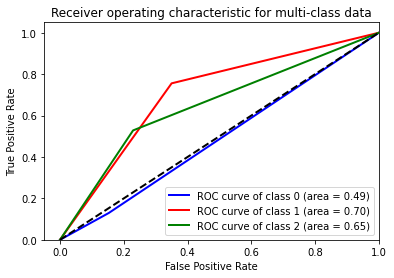

In [ ]:
#@title Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
lw = 2
for i in range(n_classes):
    
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_preds_bin[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.savefig(pathtoSave + 'roc_curve_test_5s.png')

In [ ]:
#@title Save performance results
cls = classification_report(y_test, y_preds, output_dict=True)
clsf_report = pd.DataFrame(cls).transpose()
clsf_report.to_csv(pathtoSave + 'classification_report_5s_test.csv', index= True)

In [ ]:
#@title Remove dataframe and model
del df
del model
del y_test_bin
del y_preds_bin

# Test 2 seconds images

In [ ]:
#@title Folder for SVM maker 
RootDir = pathtoTimingsImages + 'Test_2s'
TargetFolder = pathtoTarget + 'test_2s'
for root, dirs, files in os.walk((os.path.normpath(RootDir)), topdown=False):
        for name in files:
            if name.endswith('.jpg'):
                print ("Found")
                SourceFolder = os.path.join(root,name)
                shutil.copy2(SourceFolder, TargetFolder) #copies csv to new folder

Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Found
Foun

In [ ]:
#@title Conditions folders
rootdir = pathtoSVMImages + 'test_2s'
output_path = pathtoSVMImages + 'test_2s/'
csv = pathtoCSV + 'test_L1L2.csv'
no_ds = pd.read_csv(csv)
print(no_ds.columns)

for name in no_ds['code'][no_ds['Levels']==0]:
  os.rename(rootdir+'/'+name, rootdir+'/cooperative/'+name)

for name in no_ds['code'][no_ds['Levels']==1]:
  os.rename(rootdir+'/'+name, rootdir+'/Level_1/'+name)

for name in no_ds['code'][no_ds['Levels']==2]:
  os.rename(rootdir+'/'+name, rootdir+'/equilibrium/'+name)

Index(['code', 'Levels'], dtype='object')


In [ ]:
#@title Eliminate images outside of category folders
%%bash
cd /content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/Test_SVM_Levels/test_2s/cooperative
ls -d | wc *.jpg

   4764    6171  159504 fase1_048e1_7.jpg
   1243    2679  156828 fase1_055e1_5.jpg
   1261    2681  161552 fase1_055e1_6.jpg
   1094    2487  151496 fase1_055e1_9.jpg
   1456    2917  163846 fase1_063e1_8.jpg
    944    2552  152294 fase1_063e1_9.jpg
   5079    6388  149873 fase1_064e1_1.jpg
   1182    2572  154268 fase1_06e2_11.jpg
   1097    2581  158743 fase1_06e2_13.jpg
   1640    3039  153445 fase1_06e2_6.jpg
   1470    2847  157508 fase1_070e1_12.jpg
   1153    2453  147673 fase1_070e1_15.jpg
   1207    2521  155490 fase1_070e1_6.jpg
   1044    2375  150728 fase1_076e1_10.jpg
   4912    6297  157382 fase1_076e1_14.jpg
   1450    2982  163666 fase1_076e1_1.jpg
   1220    2609  157923 fase1_076e1_2.jpg
   1076    2318  150508 fase1_076e1_3.jpg
   4591    5941  152156 fase1_079e1_11.jpg
    856    2327  159309 fase1_079e1_13.jpg
   1030    2440  160422 fase1_079e1_9.jpg
    964    2154  141676 fase1_089e1_11.jpg
   1050    2876  174293 fase1_089e1_15.jpg
    912    2258  158140 fas

In [ ]:
#@title SVM dataframe maker

flat_data_arr=[]
target_arr=[]
#please use datadir='/content' if the files are upload on to google collab
#else mount the drive and give path of the parent-folder containing all category images folders.
datadir=pathtoSVMImages + 'test_2s'
for i in Categories:
  print(f'loading... category : {i}')
  path=os.path.join(datadir,i)
  for img in os.listdir(path):
    img_array=imread(os.path.join(path,img))
    img_resized=resize(img_array,(224,224,3))
    flat_data_arr.append(img_resized.flatten())
    target_arr.append(Categories.index(i))
  print(f'loaded category:{i} successfully')
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data)
df['Target']=target
df

df.to_pickle(pathtoSVMImages + 'test_2s/svm_df.pkl')

loading... category : cooperative
loaded category:cooperative successfully
loading... category : Level_1
loaded category:Level_1 successfully
loading... category : equilibrium
loaded category:equilibrium successfully


In [ ]:
#@title Load dataframe
df = pd.read_pickle(pathtoSVMImages + 'test_2s/svm_df.pkl')

In [ ]:
#@title Load model
model = pickle.load(open(pathtoModel + 'svm_model_Strategic_sophistication.p','rb')) 
print(model)

SVC(C=10, gamma=0.0001)


In [ ]:
#@title Model predictions
x_test=df.iloc[:,:-1]
y_test=df.iloc[:,-1]
y_preds = model.predict(x_test)

In [ ]:
#@title Performance measures

#Classification report
print(classification_report(y_test, y_preds))

# get accuracy and confusion matrix:
print(f"The model is {accuracy_score(y_preds,y_test)*100}% accurate")
print(confusion_matrix(y_preds,y_test))

              precision    recall  f1-score   support

           0       0.22      0.24      0.23        54
           1       0.39      0.73      0.51        90
           2       0.74      0.16      0.26       106

    accuracy                           0.38       250
   macro avg       0.45      0.38      0.34       250
weighted avg       0.50      0.38      0.35       250

The model is 38.4% accurate
[[13 22 24]
 [37 66 65]
 [ 4  2 17]]


In [ ]:
#@title Save roc_auc 
labels = [0,1,2]
# Binarize ytest with shape (n_samples, n_classes)
y_test_bin = label_binarize(y_test, classes=labels)
# Binarize ypreds with shape (n_samples, n_classes)
y_preds_bin = label_binarize(y_preds, classes=labels)
macro = roc_auc_score(y_test_bin, y_preds_bin,average='macro',multi_class='ovr')
weighted = roc_auc_score(y_test_bin, y_preds_bin,average='weighted',multi_class='ovr')
roc = {'macro':  [macro],
        'weighted': [weighted],
        }
roc = pd.DataFrame(roc)
roc.to_csv(pathtoSave + 'roc_report_test_2s.csv', index= True)

In [ ]:
# Compute mapk:
mapk_2s = mapk(y_test_bin, y_preds_bin,k)
mapk_2s

0.7054583333333345

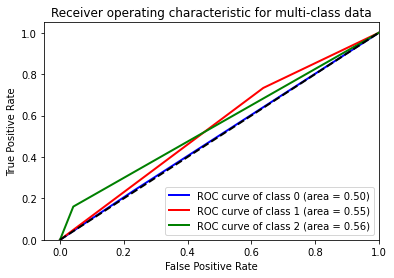

In [ ]:
#@title Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
lw = 2
for i in range(n_classes):
    
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_preds_bin[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.savefig(pathtoSave + 'roc_curve_test_2s.png')

In [ ]:
#@title Save performance results
cls = classification_report(y_test, y_preds, output_dict=True)
clsf_report = pd.DataFrame(cls).transpose()
clsf_report.to_csv(pathtoSave + 'classification_report_2s_test.csv', index= True)

In [ ]:
#@title Remove dataframe and model
del df
del model

# Save mapk results as CSV

In [ ]:
mapk_val = pd.read_csv(pathtoSave + 'mapk_val.csv')

In [ ]:
data1 = {'dataset':  ['val','full', '15s', '10s', '5s', '2s'],
        'mapk': [mapk_val.iloc[0,1], mapk_full, mapk_15s, mapk_10s, mapk_5s, mapk_2s],
        }

data1 = pd.DataFrame(data1)
data1.to_csv(pathtoSave + 'mapk_timings.csv', index= True)

data2 = {'dataset':  ['val', 'full', '80', '50', '30', '15'],
        'mapk': [ mapk_val.iloc[0,1],mapk_full, mapk_80, mapk_50, mapk_30, mapk_15],
        }

data2 = pd.DataFrame(data2)
data2.to_csv(pathtoSave + 'mapk_percentages.csv', index= True)

In [ ]:

def plot_metrics(data1, data2, name_file):
  metrics = ['mapk_timings', 'mapk_percentages']
  fig, ax = plt.subplots(1,2, figsize=(30,20))
  fig.suptitle('Mean average precision at k for SVM',fontsize=40)
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    mtc = metric.split("_", 1)[0]
    plt.subplot(1,2,n+1)
    if n ==0:
      plt.plot(data1.iloc[:,0], data1[mtc], linewidth=3)
    elif n % 2 == 0:
      plt.plot(data1.iloc[:,0], data1[mtc], linewidth=3)
    else:
      plt.plot(data2.iloc[:,0], data2[mtc], linewidth=3)
    plt.xlabel('Dataset', fontsize=10)
    plt.title(str(name))
    plt.savefig(pathtoSave + name_file)

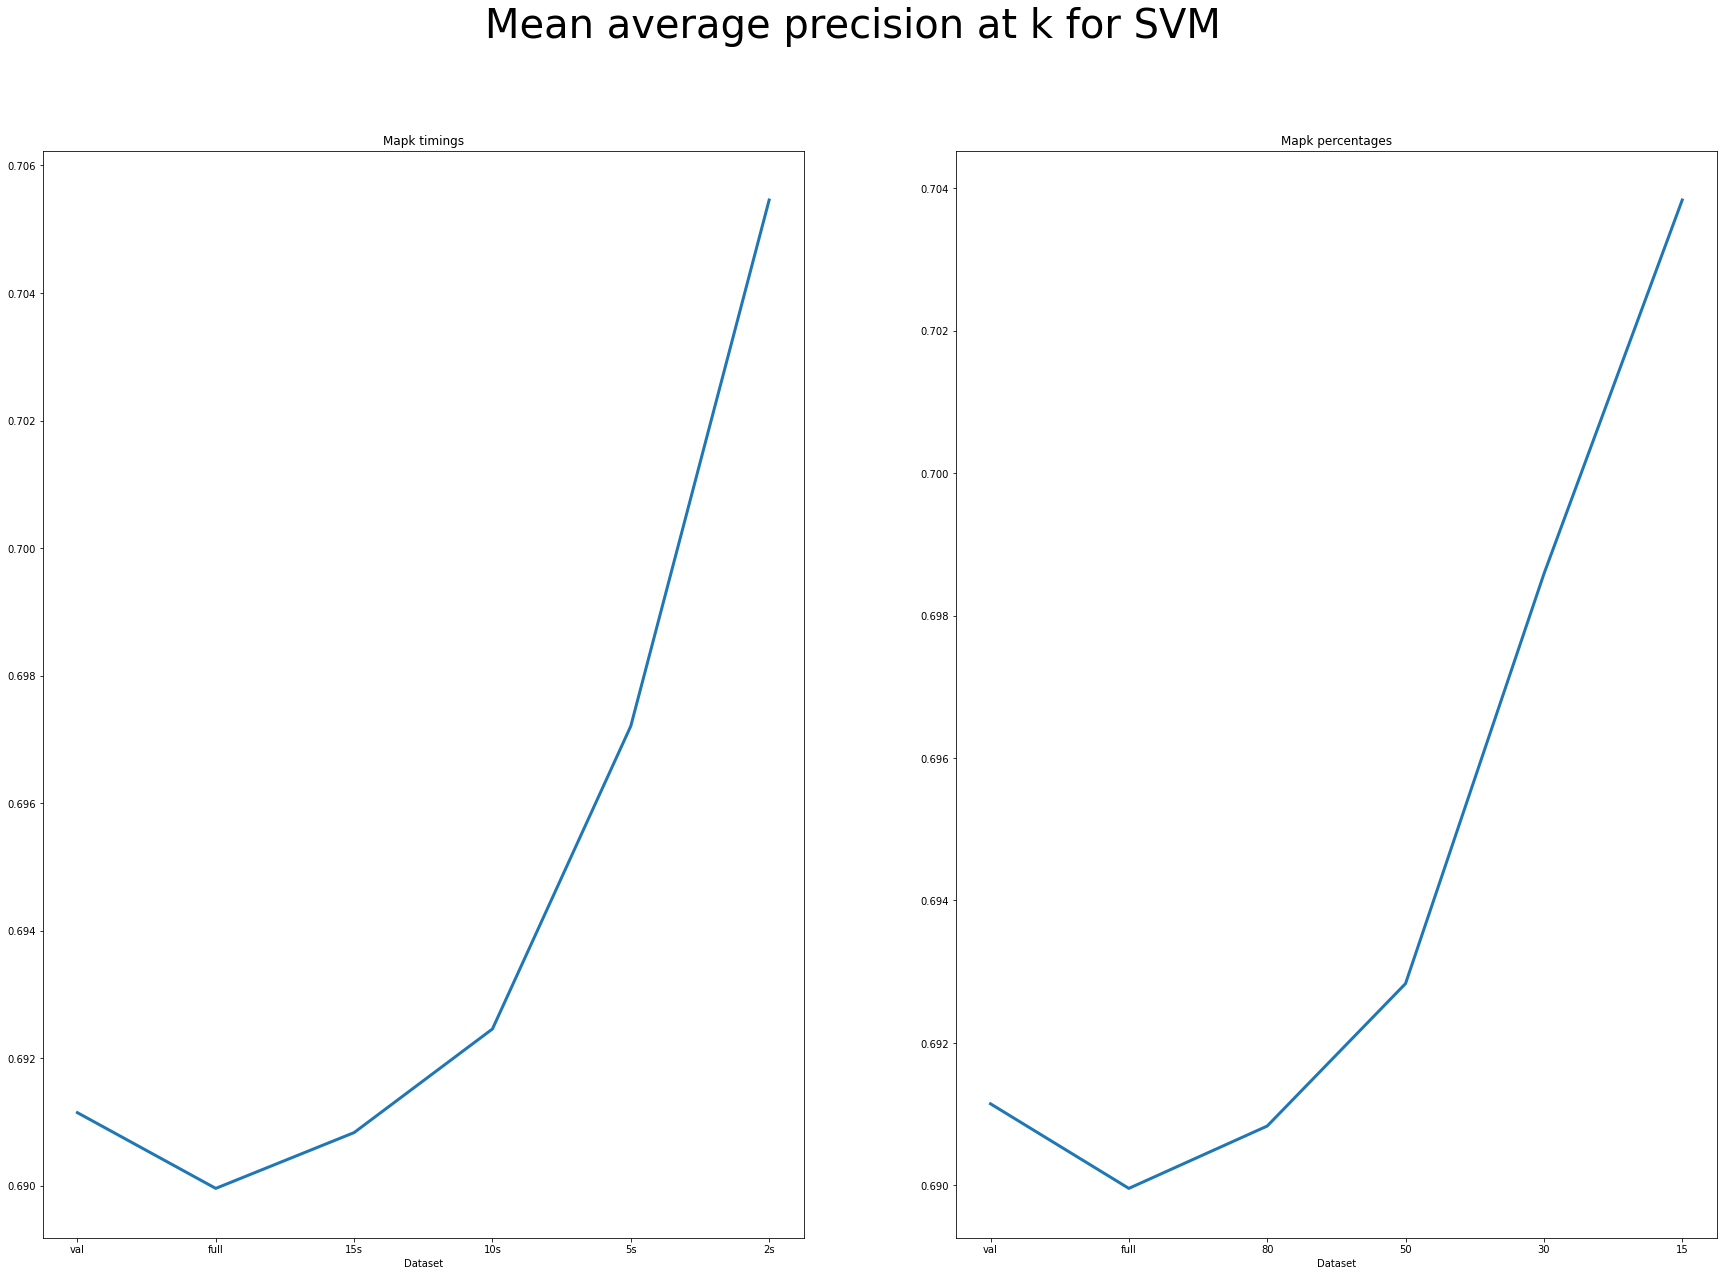

In [ ]:
plot_metrics(data1, data2, 'results_mapk_SVM_strategic_sophistication.png')